# About Brain Tumor
*A brain tumor is a mass or growth of abnormal cells in your brain. Many different types of brain tumors exist. Some brain tumors are noncancerous (benign), and some brain tumors are cancerous (malignant).*

*Brain tumors can begin in your brain (primary brain tumors), or cancer can begin in other parts of your body and spread to your brain as secondary (metastatic) brain tumors.*

*How quickly a brain tumor grows can vary greatly. The growth rate as well as the location of a brain tumor determines how it will affect the function of your nervous system.*

*Brain tumor treatment options depend on the type of brain tumor you have, as well as its size and location.*

## Problem Definition
*Brain Tumors are complex. There are a lot of abnormalities in the sizes and location of the brain tumor(s). This makes it really difficult for complete understanding of the nature of the tumor. Also, a professional Neurosurgeon is required for MRI analysis. Often times in developing countries the lack of skillful doctors and lack of knowledge about tumors makes it really challenging and time-consuming to generate reports from MRI’. So an automated system on Cloud can solve this problem.*

## Task
*Detect and Classify Brain Tumor using **CNN** .*

# Import Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import plotly.graph_objects as go
import plotly.express as px

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model,Sequential
from keras.layers import Flatten,Activation,Dense,Dropout,Conv2D,MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping



# Load Dataset

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:
train_dir= '/kaggle/input/brain-tumor-mri-images/archive (5)/Training'
test_dir = '/kaggle/input/brain-tumor-mri-images/archive (5)/Testing'

batch_size = 32
img_height = 224
img_width = 224

In [4]:
train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=143,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode= 'int'
)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.


2022-11-11 11:40:00.054774: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
val_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=143,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode= 'int'
)

Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


# EDA

In [6]:
class_names= train_data.class_names
print(class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


2022-11-11 11:40:00.923066: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


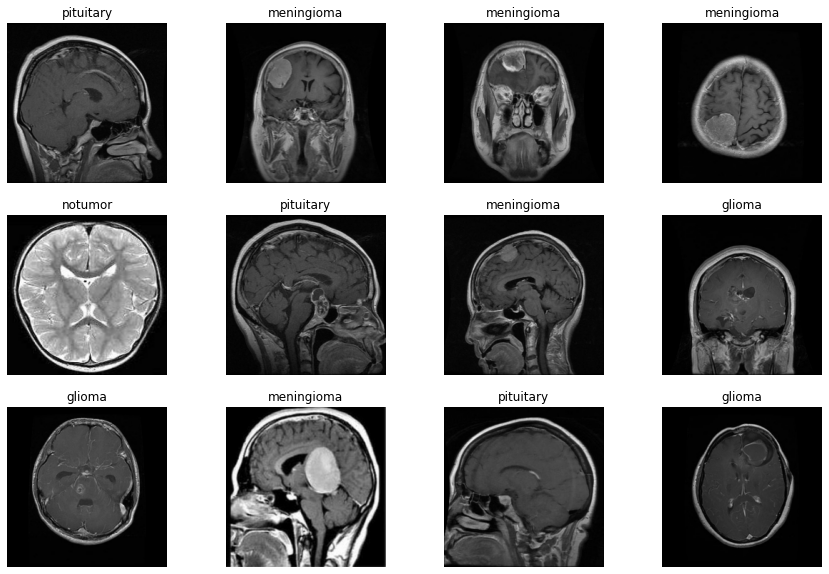

In [7]:
plt.figure(figsize=(15, 10))
for images, labels in train_data.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [8]:
meningioma = 0
notumor = 0
glioma = 0
pituitary = 0

for images, labels in train_data:
    for i in range(len(images)):
        #print(class_names[labels[i]])
        if class_names[labels[i]] == 'meningioma':
            meningioma +=1
        elif class_names[labels[i]] == 'notumor':
            notumor +=1
        elif class_names[labels[i]] == 'glioma':
            glioma +=1
        elif class_names[labels[i]] == 'pituitary':
            pituitary +=1
            
            
print('meningioma : ', meningioma)
print('glioma : ', glioma)
print('pituitary : ', pituitary)
print('notumor : ', notumor)

Cleanup called...
Cleanup called...


meningioma :  1073
glioma :  1055
pituitary :  1157
notumor :  1285


## Balanced or Not ?

In [9]:
fig=px.pie(values = [meningioma+glioma+pituitary,notumor], names=['tumor','notumor'],hole=0.425)
fig.update_layout(title='Brain Tumor Distribution',font_size=15,title_x=0.45,annotations=[dict(text='BrainTumor',font_size=18, showarrow=False,height=800,width=700)])
fig.update_traces(textfont_size=15,textinfo='percent')
fig.show()

In [10]:
fig = go.Figure(go.Bar(
            x= [meningioma,glioma,pituitary,notumor],
            y= ['meningioma','glioma','pituitary','notumor'],
            orientation='h'))

fig.update_layout(title='Brain Tumor Distribution',font_size=15,title_x=0.45)


fig.show()

In [11]:
fig=px.pie(values = [meningioma,glioma,pituitary,notumor], names=['meningioma','glioma','pituitary','notumor'],hole=0.425)
fig.update_layout(title='Brain Tumor Distribution',font_size=15,title_x=0.45,annotations=[dict(text='BrainTumor',font_size=18, showarrow=False,height=800,width=700)])
fig.update_traces(textfont_size=15,textinfo='percent')
fig.show()

Yes, it is balanced. 'D

# Model

In [12]:
from keras_preprocessing.image import ImageDataGenerator

trainDataGenerator = ImageDataGenerator(rescale=1./255, validation_split=0.2)
testDataGenerator = ImageDataGenerator(rescale=1./255)

In [13]:
train_d = trainDataGenerator.flow_from_directory(
     "../input/brain-tumor-mri-images/archive (5)/Training",
      classes=['glioma','meningioma','notumor','pituitary'],
      color_mode="rgb",
      batch_size=16,
      target_size=(64,64),
      class_mode="categorical",
      subset="training")

valid_d = trainDataGenerator.flow_from_directory(
    "../input/brain-tumor-mri-images/archive (5)/Training",
    classes=['glioma','meningioma','notumor','pituitary'],
    color_mode="rgb",
    batch_size=16,
    target_size=(64,64),
    class_mode="categorical",
    subset="validation"
)

test_d = testDataGenerator.flow_from_directory(
    "../input/brain-tumor-mri-images/archive (5)/Testing",
    classes = ['glioma','meningioma','notumor','pituitary'],
    color_mode="rgb",
    target_size=(64,64))

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [14]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras import callbacks

import matplotlib.pyplot as plt

In [19]:
model = Sequential()
model.add(Conv2D(64*64,(3,3), input_shape=(64,64,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3), padding="same", activation="relu"))
model.add(Dropout(rate=0.4))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3), padding="same", activation="relu"))
model.add(Dropout(rate=0.2))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(16, activation="relu"))
model.add(Dropout(rate=0.2))

model.add(Dense(4, activation="softmax"))

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
callback_list=[
    callbacks.EarlyStopping(monitor="val_accuracy",patience=10,restore_best_weights=True),
    callbacks.ReduceLROnPlateau(factor=0.8,monitor="val_accuracy",patience=3)
]

In [21]:
history = model.fit(train_d,validation_data=valid_d,epochs=5,verbose=1,callbacks=callback_list)

Epoch 1/5
286/286 [==============================] - 1265s 4s/step - loss: 0.3756 - accuracy: 0.6589 - val_loss: 0.3994 - val_accuracy: 0.6670
Epoch 2/5
286/286 [==============================] - 1265s 4s/step - loss: 0.2552 - accuracy: 0.8033 - val_loss: 0.3471 - val_accuracy: 0.6915
Epoch 3/5
286/286 [==============================] - 1261s 4s/step - loss: 0.2040 - accuracy: 0.8385 - val_loss: 0.3226 - val_accuracy: 0.7502
Epoch 4/5
286/286 [==============================] - 1258s 4s/step - loss: 0.1825 - accuracy: 0.8543 - val_loss: 0.3163 - val_accuracy: 0.7607
Epoch 5/5
286/286 [==============================] - 1260s 4s/step - loss: 0.1604 - accuracy: 0.8685 - val_loss: 0.2897 - val_accuracy: 0.7984


In [23]:
def plotRes(history):
    plt.figure(1, figsize = (15,8)) 
    
    plt.subplot(221)  
    plt.plot(history.history['accuracy'])  
    plt.plot(history.history['val_accuracy'])  
    plt.title('model accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'valid']) 
    
    plt.subplot(222)  
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'valid']) 

    plt.show()

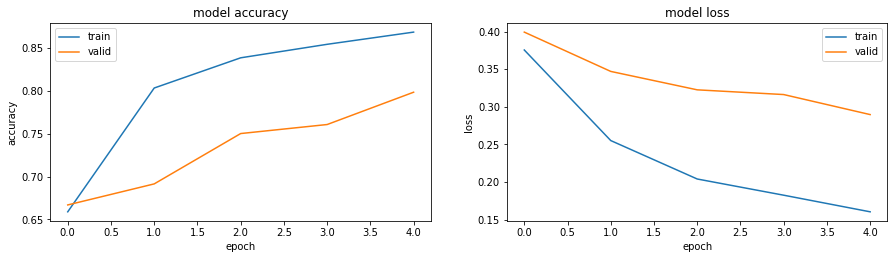

In [24]:
plotRes(history)